A few questions need to be answer:

1. From the training dataset, how do we choose the actions? The actions will be derived from the resp and weights data, how do we use these data? (may need some domain knowledge, there are also many notebooks around trying to de-anonymize the feactures and tags)

2. How to use the feature file? Can we use it for reducing the dimension? What are other ways needed to preprocess the data?

3. What visualization tools can we use to understand the data?

4. What target value do we want to predict directly? resps or action? Which machine learning models shall we use?

5. Given the constraints on running time, how can we speed up?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py
/kaggle/input/k/yidancai/stock-market-prediction/xgb2.model
/kaggle/input/k/yidancai/stock-market-prediction/__results__.html
/kaggle/input/k/yidancai/stock-market-prediction/submission.csv
/kaggle/input/k/yidancai/stock-market-prediction/__notebook__.ipynb
/kaggle/input/k/yidancai/stock-market-prediction/__output__.json
/kaggle/input/k/yidancai/stock-market-prediction/custom.css
/kaggle/input/k/yidancai/stock-market-prediction/__results___files/__results___15_0.png
/kaggle/input/k/yidancai/stock-market-prediction/__results___files/__results___9_0.png


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.model_selection import train_test_split
import datatable as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
%%time
train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')
feature_datatable =  dt.fread('../input/jane-street-market-prediction/features.csv')
example_test = dt.fread('../input/jane-street-market-prediction/example_test.csv')
example_test = example_test.to_pandas()
train_data = train_data_datatable.to_pandas()

CPU times: user 32.8 s, sys: 11.1 s, total: 43.9 s
Wall time: 37.5 s


# visualization 
graph network 
[🌐EDA: Tag Network Analysis (networkx + gephi)🌐](https://www.kaggle.com/quillio/eda-tag-network-analysis-networkx-gephi)

[Jane Street: t-SNE using RAPIDS cuML](https://www.kaggle.com/carlmcbrideellis/jane-street-t-sne-using-rapids-cuml)

[Target Engineering; CV; ✊ fast.ai Multi-Target](https://www.kaggle.com/marketneutral/target-engineering-cv-fast-ai-multi-target) shows the overall trend of resp and resp * weight

Also notice cumulative resp and return (resp*weight) for feature_0 =1 and feature_0 = -1 are different [An observation about feature_0](https://www.kaggle.com/c/jane-street-market-prediction/discussion/204963)

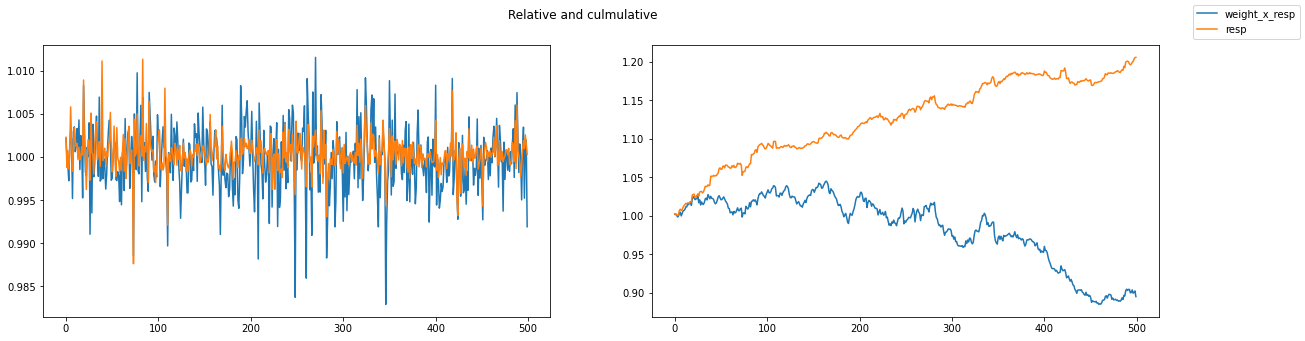

In [4]:
train_data['weight_x_resp'] = train_data['weight']*train_data['resp']


a =1+(train_data.groupby('date')['weight_x_resp'].mean())
b = 1+(train_data.groupby('date')['resp'].mean())


c = (1+(train_data.groupby('date')['weight_x_resp'].mean())).cumprod()
d =(1+(train_data.groupby('date')['resp'].mean())).cumprod()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Relative and culmulative')
ax1.plot(a)
ax1.plot(b)

ax2.plot(c)
ax2.plot(d)
fig.legend(labels = ['weight_x_resp','resp']);

Feature Engineering 

The xgboost model takes quite a long time when testing using CPU, so reducing features is considered.

Using PCA, reference [Jane : EDA & Feature Selection](https://www.kaggle.com/shahules/jane-eda-feature-selection)

or select some features, Reference
[Jane Day 242 Feature Generation and Selection](https://www.kaggle.com/rajkumarl/jane-day-242-feature-generation-and-selection)

In [5]:
feature_names = ['feature_'+str(i) for i in range(130)]
# feature_names = [ 'feature_1', 'feature_2', 'feature_6', 'feature_9',
#        'feature_10', 'feature_16', 'feature_20', 'feature_29', 'feature_37',
#        'feature_38', 'feature_39', 'feature_40', 'feature_51', 'feature_52',
#        'feature_53', 'feature_54', 'feature_69', 'feature_70', 'feature_71',
#        'feature_83', 'feature_100', 'feature_109', 'feature_112',
#        'feature_122', 'feature_123', 'feature_124', 'feature_126',
#        'feature_128', 'feature_129','weight']

x = train_data.loc[:, feature_names].values
# x = StandardScaler().fit_transform(x) # normalizing the features
# normalised_train = pd.DataFrame(x,columns=feature_names)
# pca_train = PCA(n_components=2)
# principalComponents_train = pca_train.fit_transform(x)

In [6]:

bst = xgb.Booster()  # init model
bst.load_model('/kaggle/input/k/yidancai/stock-market-prediction/xgb2.model')  # load data

In [7]:
# the difference between version 8 and 7 is the threshold, version 7 : 0, version 8, 0.1
to_action = lambda t: 1 * (t > 0.1)

In [8]:


test_data =  example_test.loc[:, feature_names]
test_matrix = xgb.DMatrix(test_data)

# y_preds = np.round(bst.predict(test_matrix))
y_preds = to_action(np.multiply(bst.predict(test_matrix),test_data['weight']))
print(y_preds)

KeyError: 'weight'

In [9]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set


for (test_df, sample_prediction_df) in iter_test:
    if test_df['weight'].item() > 0:
        test = test_df.loc[:, feature_names]
        test = test.fillna(0)
#         print(X_test.shape)
        test_matrix = xgb.DMatrix(test)
        y_preds = to_action(np.multiply(bst.predict(test_matrix),test_df['weight']))
        sample_prediction_df.action = y_preds.astype(int)  #make your 0/1 prediction here
    else:
        sample_prediction_df.action = 0
    env.predict(sample_prediction_df)